<a href="https://colab.research.google.com/github/IAT-ExploringAI-2024/Computer-Vision-Project/blob/main/ComputerVisionProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
import seaborn as sns
import glob
import xml.etree.ElementTree as ET
from PIL import Image
import os
import shutil

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
test_dir = '/content/drive/MyDrive/test'
train_dir = '/content/drive/MyDrive/train'

In [ ]:
#import os
#run it once for making directories

#os.makedirs('/content/drive/MyDrive/Datasets/Final_data')
os.makedirs('/content/drive/MyDrive/Datasets/Final_data/images')
os.makedirs('/content/drive/MyDrive/Datasets/Final_data/labels')
os.makedirs('/content/drive/MyDrive/Datasets/Final_data/images/train')
os.makedirs('/content/drive/MyDrive/Datasets/Final_data/images/val')
os.makedirs('/content/drive/MyDrive/Datasets/Final_data/labels/train')
os.makedirs('/content/drive/MyDrive/Datasets/Final_data/labels/val')

In [ ]:
#set the paths to labels and images directory
label_dir= "/content/drive/MyDrive/Datasets/Final_data/labels"
image_dir="/content/drive/MyDrive/Datasets/Final_data/images"

# Custom object detection using YOLO

First install and import

In [3]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 39.7/112.6 GB disk)


In [4]:
from ultralytics import YOLO

## Training YOLO

Wrote /content/drive/MyDrive/Datasets/bikelane_autogen.yaml
Detected class IDs: [0, 1, 2, 3, 4, 5, 6]
Names: {0: 'bikelane', 1: 'class_1', 2: 'class_2', 3: 'class_3', 4: 'class_4', 5: 'class_5', 6: 'class_6'}
Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Datasets/bikelane_autogen.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=30

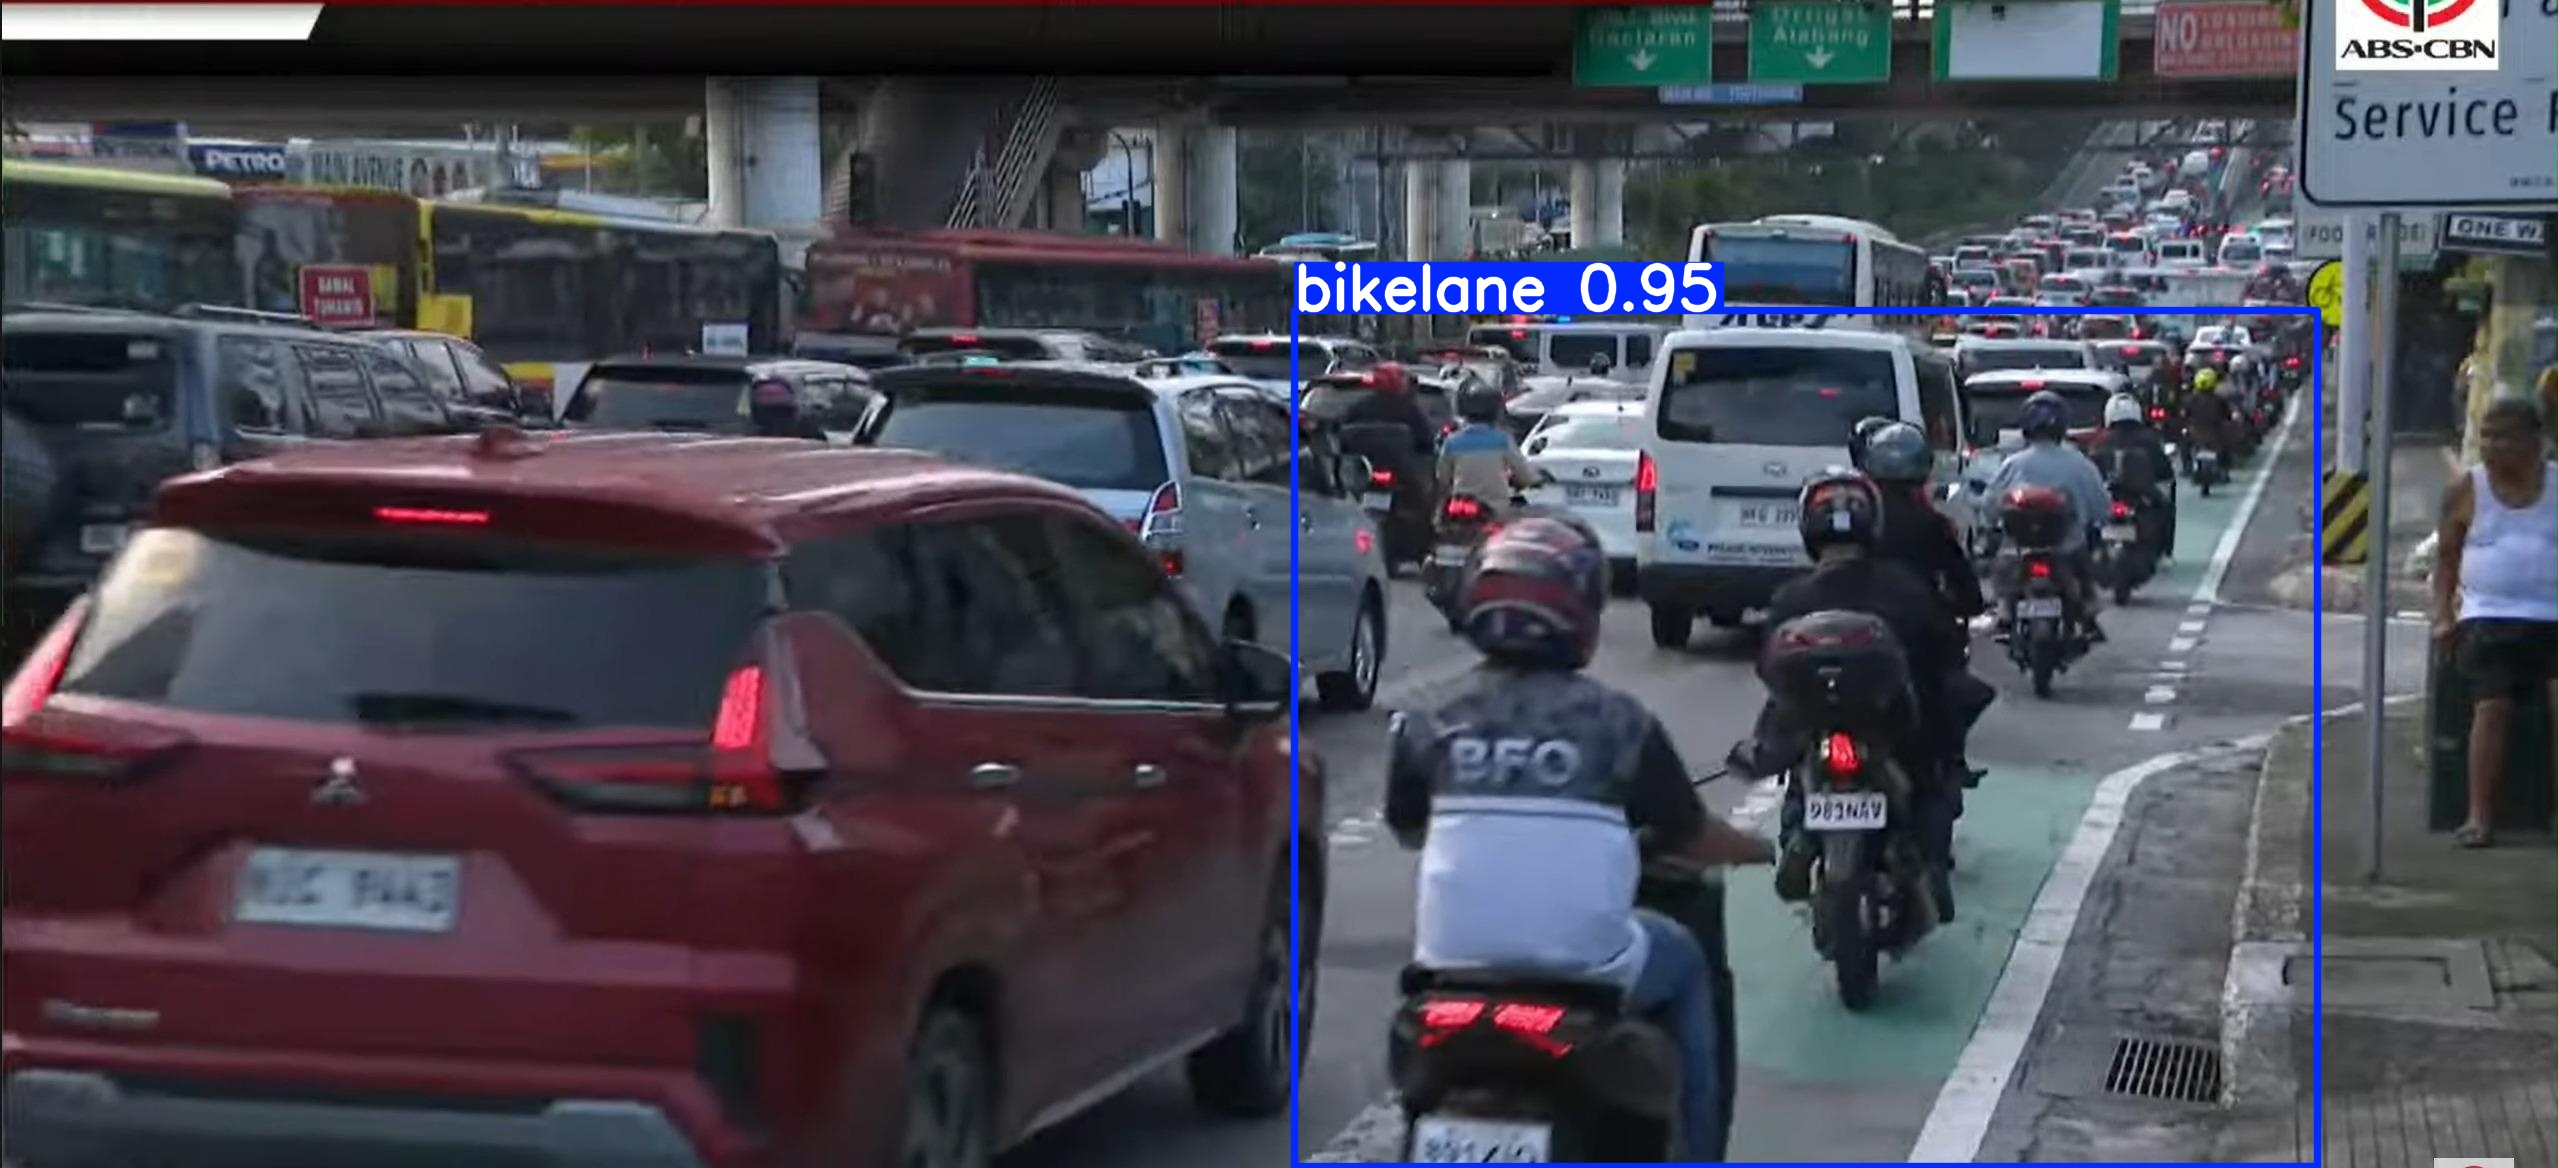

In [10]:
import os, glob, yaml
from ultralytics import YOLO
from IPython.display import Image as IPyImage, display

DATA_ROOT = "/content/drive/MyDrive/Datasets"
IMG_TRAIN = f"{DATA_ROOT}/Final_data/images/train"
IMG_VAL   = f"{DATA_ROOT}/Final_data/images/val"
LBL_TRAIN = f"{DATA_ROOT}/Final_data/labels/train"
LBL_VAL   = f"{DATA_ROOT}/Final_data/labels/val"


for p in [IMG_TRAIN, IMG_VAL, LBL_TRAIN, LBL_VAL]:
    assert os.path.isdir(p), f"Missing folder: {p}"


def detect_class_ids(*label_dirs):
    ids = set()
    for d in label_dirs:
        for lp in glob.glob(os.path.join(d, "*.txt")):
            with open(lp) as f:
                for ln in f:
                    parts = ln.strip().split()
                    if len(parts) >= 5:
                        try:
                            cid = int(float(parts[0]))
                            if cid >= 0: ids.add(cid)
                        except:
                            pass
    return sorted(ids)

present_ids = detect_class_ids(LBL_TRAIN, LBL_VAL)
assert len(present_ids) > 0, "No class IDs found in labels."

names = {i: ("bikelane" if i == 0 else f"class_{i}") for i in present_ids}
DATA_YAML = os.path.join(DATA_ROOT, "bikelane_autogen.yaml")
with open(DATA_YAML, "w") as f:
    yaml.safe_dump({
        "train": IMG_TRAIN,
        "val": IMG_VAL,
        "nc": max(present_ids)+1,
        "names": names
    }, f, sort_keys=False)
print("Wrote", DATA_YAML)
print("Detected class IDs:", present_ids)
print("Names:", names)

model = YOLO("yolov8s.pt")
results = model.train(
    data=DATA_YAML,
    epochs=60,
    patience=20,
    batch=16,
    imgsz=640
)

save_dir = str(results.save_dir)
best_pt  = os.path.join(save_dir, "weights", "best.pt")
last_pt  = os.path.join(save_dir, "weights", "last.pt")
weights  = best_pt if os.path.exists(best_pt) else last_pt
print("Using weights:", weights)

detector = YOLO(weights)
print("Model classes:", detector.names)

def show_saved(pred, src_path):
    out_dir = pred[0].save_dir
    out_path = os.path.join(out_dir, os.path.basename(src_path))
    print("Saved:", out_path)
    display(IPyImage(filename=out_path, width=900))

#Predict on a known pic
val_imgs = sorted(glob.glob(os.path.join(IMG_VAL, "*.jpg")) + glob.glob(os.path.join(IMG_VAL, "*.png")))
assert val_imgs, f"No images found in {IMG_VAL}"
src_in_domain = val_imgs[0]
pred = detector.predict(
    source=src_in_domain,
    conf=0.15,
    save=True,
    project="/content/runs/detect",
    name="predict_val_check"
)
show_saved(pred, src_in_domain)




Saved vis: /content/runs/detect/motorcycle BLOCKING 1.00/Screen-Recording-2025-07-21-134241_mp4-0002_jpg.rf.aa36f35043f418791652c6d314189af1.jpg


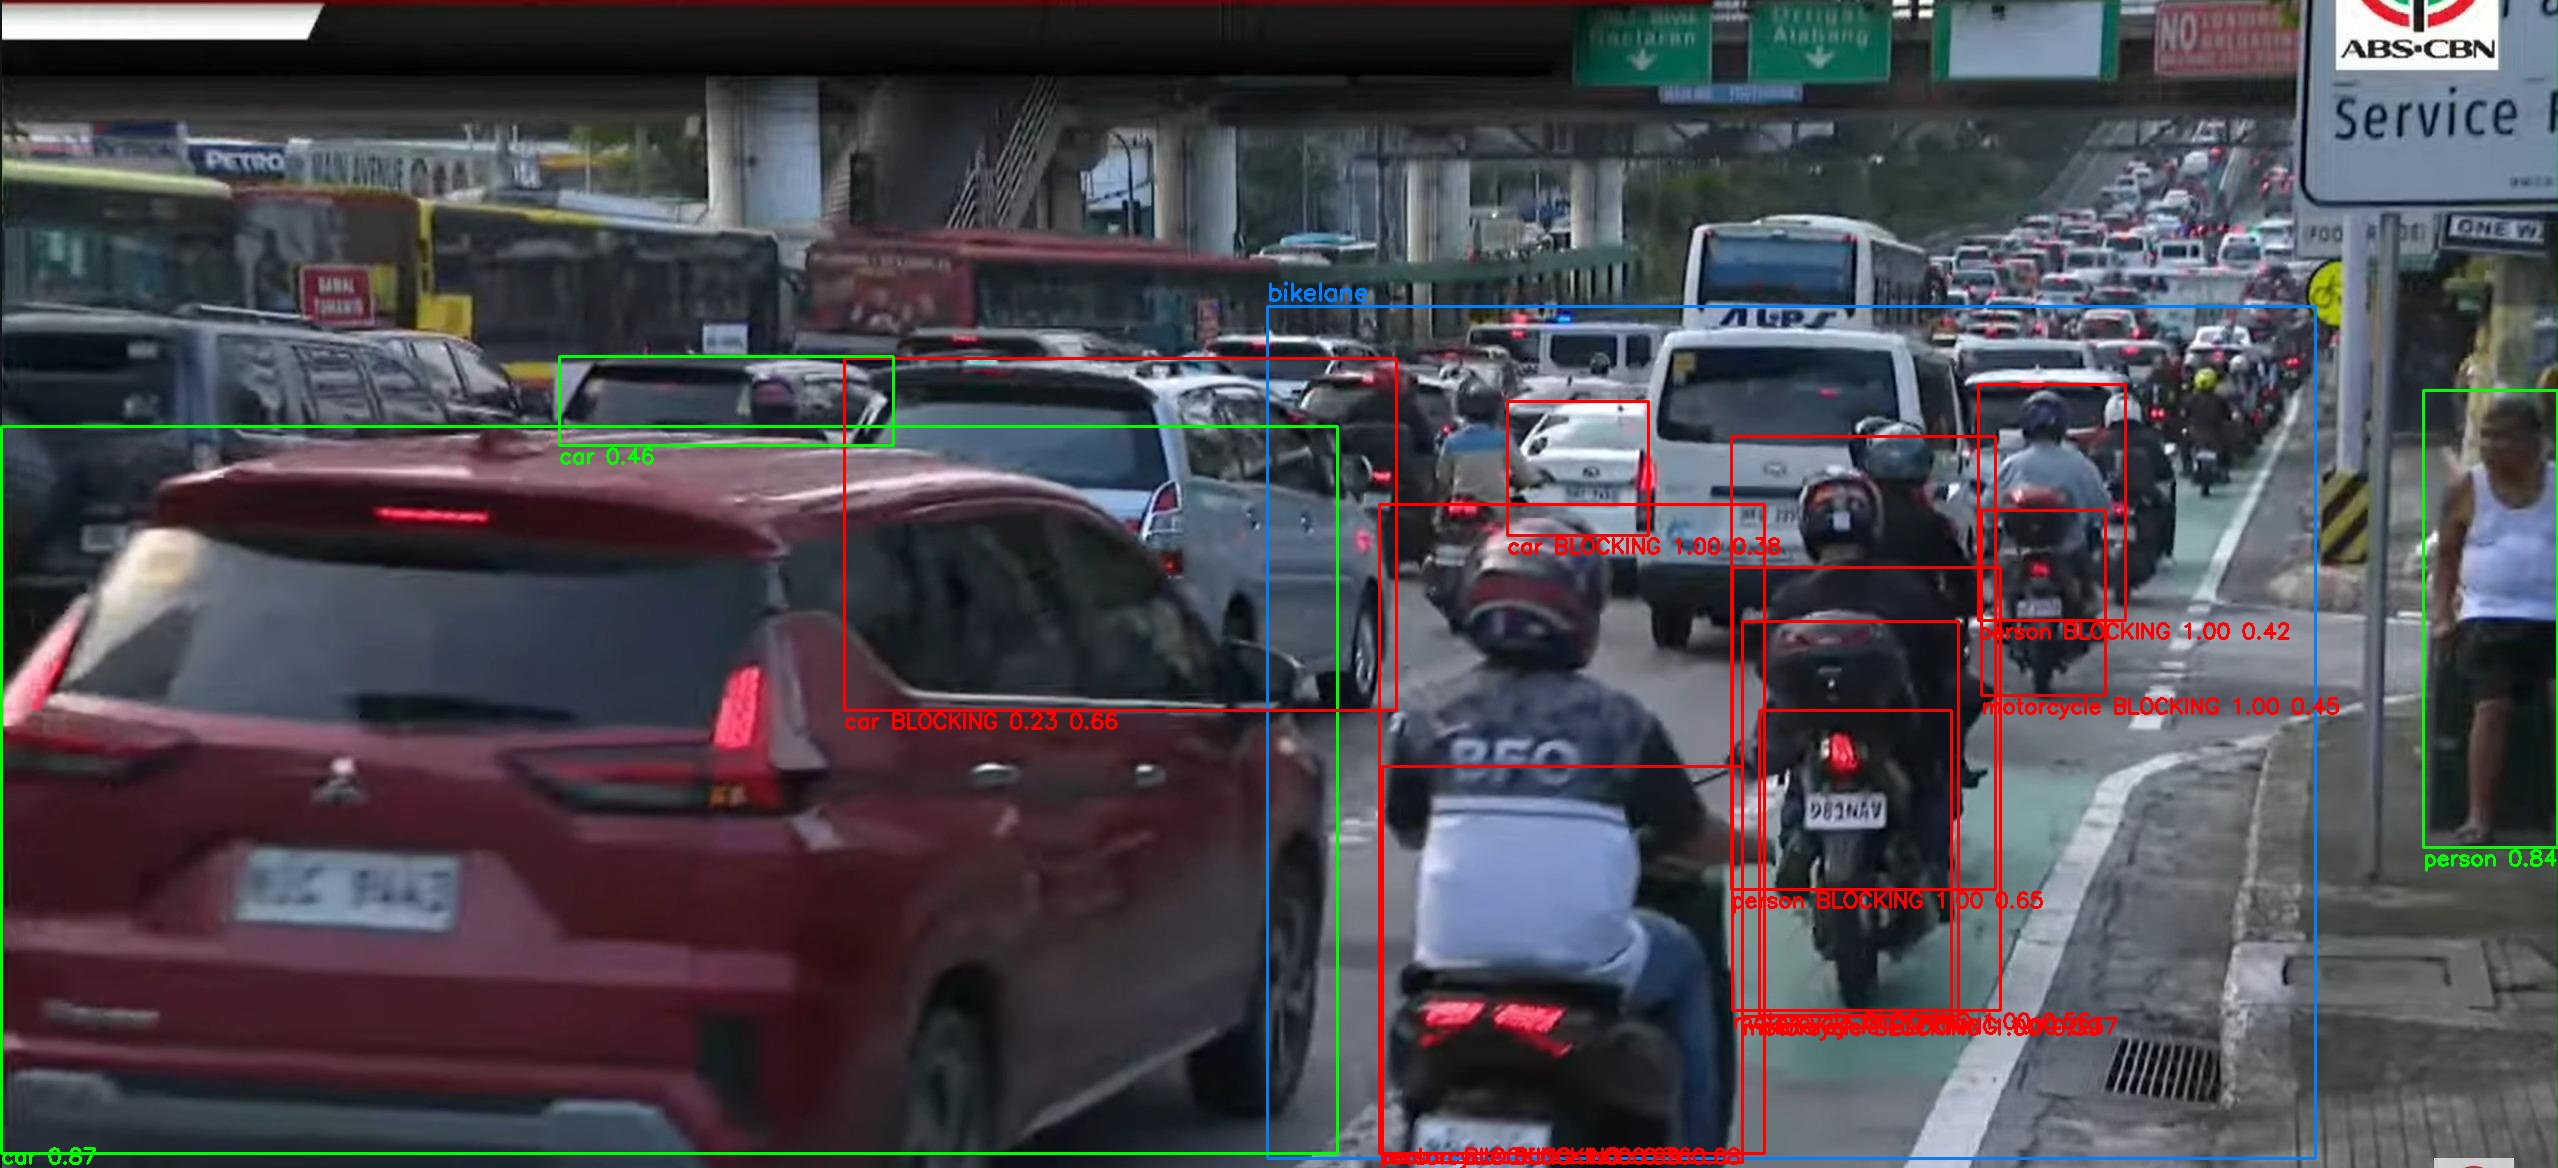

RESULT: BLOCKED
 - person conf=0.76 overlap=1.00
 - motorcycle conf=0.68 overlap=0.99
 - car conf=0.66 overlap=0.23
 - person conf=0.65 overlap=1.00
 - motorcycle conf=0.56 overlap=1.00
 - motorcycle conf=0.45 overlap=1.00
 - person conf=0.42 overlap=1.00
 - motorcycle conf=0.39 overlap=1.00
 - car conf=0.38 overlap=1.00
 - motorcycle conf=0.37 overlap=1.00


In [14]:
obstacle_model = YOLO("yolov8n.pt")  # pretrained on COCO

BLOCKER_NAMES = {
    "person","bicycle","car","motorcycle","bus","truck","train","traffic light",
    "fire hydrant","stop sign","parking meter","bench","wheelchair",
    "traffic cone"
}

def is_blocker(name: str) -> bool:
    n = name.lower()
    return (n in BLOCKER_NAMES) or ("cone" in n)

def inter_area(a, b):
    x1 = max(a[0], b[0]); y1 = max(a[1], b[1])
    x2 = min(a[2], b[2]); y2 = min(a[3], b[3])
    w = max(0.0, x2 - x1); h = max(0.0, y2 - y1)
    return w * h

def area(box):
    return max(0.0, (box[2]-box[0])) * max(0.0, (box[3]-box[1]))

OBSTACLE_OVERLAP_FRAC = 0.20

def detect_blocking(image_path, lane_conf=0.25, obs_conf=0.35, save_vis=True,
                    project="/content/runs/detect", name="block_check"):

    lane_pred = detector.predict(source=image_path, conf=lane_conf, save=False, verbose=False)[0]
    lane_boxes = []
    if lane_pred.boxes is not None and len(lane_pred.boxes) > 0:
        for b in lane_pred.boxes:
            cls_id = int(b.cls.item())
            cls_name = detector.names.get(cls_id, str(cls_id)) if isinstance(detector.names, dict) else detector.names[cls_id]
            if cls_name.lower() == "bikelane" or cls_id == 0:
                lane_boxes.append(b.xyxy.cpu().numpy().flatten())

    obs_pred = obstacle_model.predict(source=image_path, conf=obs_conf, save=False, verbose=False)[0]
    obstacles = []
    if obs_pred.boxes is not None and len(obs_pred.boxes) > 0:
        for b in obs_pred.boxes:
            cls_id = int(b.cls.item())
            cls_name = obstacle_model.names[cls_id]
            if is_blocker(cls_name):
                obstacles.append((b.xyxy.cpu().numpy().flatten(), cls_name, float(b.conf.item())))


    blocking_hits = []
    for box, name, conf in obstacles:
        a_obs = area(box)
        if a_obs <= 0:
            continue
        for lbox in lane_boxes:
            overlap = inter_area(box, lbox)
            frac = overlap / a_obs
            if frac >= OBSTACLE_OVERLAP_FRAC:
                blocking_hits.append((box, name, conf, frac))
                break

    if save_vis:
        import cv2, os
        import numpy as np
        img = cv2.imread(image_path)
        H, W = img.shape[:2]

        # blue lanes
        for lbox in lane_boxes:
            x1,y1,x2,y2 = map(int, lbox)
            cv2.rectangle(img, (x1,y1), (x2,y2), (255,128,0), 2)
            cv2.putText(img, "bikelane", (x1, max(0,y1-6)), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,128,0), 2)

        # green not blocked red is blocked
        for box, name, conf in obstacles:
            x1,y1,x2,y2 = map(int, box)
            color = (0,255,0)
            for bh in blocking_hits:
                if np.allclose(box, bh[0]):
                    color = (0,0,255)
                    name = f"{name} BLOCKING {bh[3]:.2f}"
                    break
            cv2.rectangle(img, (x1,y1), (x2,y2), color, 2)
            cv2.putText(img, f"{name} {conf:.2f}", (x1, min(H-5, y2+18)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

        os.makedirs(os.path.join(project, name), exist_ok=True)
        out_path = os.path.join(project, name, os.path.basename(image_path))
        cv2.imwrite(out_path, img)
        print("Saved vis:", out_path)
        display(IPyImage(filename=out_path, width=900))

    is_blocked = len(blocking_hits) > 0
    print(f"RESULT: {'BLOCKED' if is_blocked else 'CLEAR'}")
    if blocking_hits:
        for _, nm, cf, frac in blocking_hits:
            print(f" - {nm} conf={cf:.2f} overlap={frac:.2f}")
    return is_blocked, blocking_hits
#test
is_blocked, hits = detect_blocking(src_in_domain, lane_conf=0.25, obs_conf=0.35,
                                   project="/content/runs/detect", name="predict_block_check")


Results saved to /content/runs/detect/predict_val_check43
Saved: /content/runs/detect/predict_val_check43/vancouver-bike-lane-pacific-street.jpg


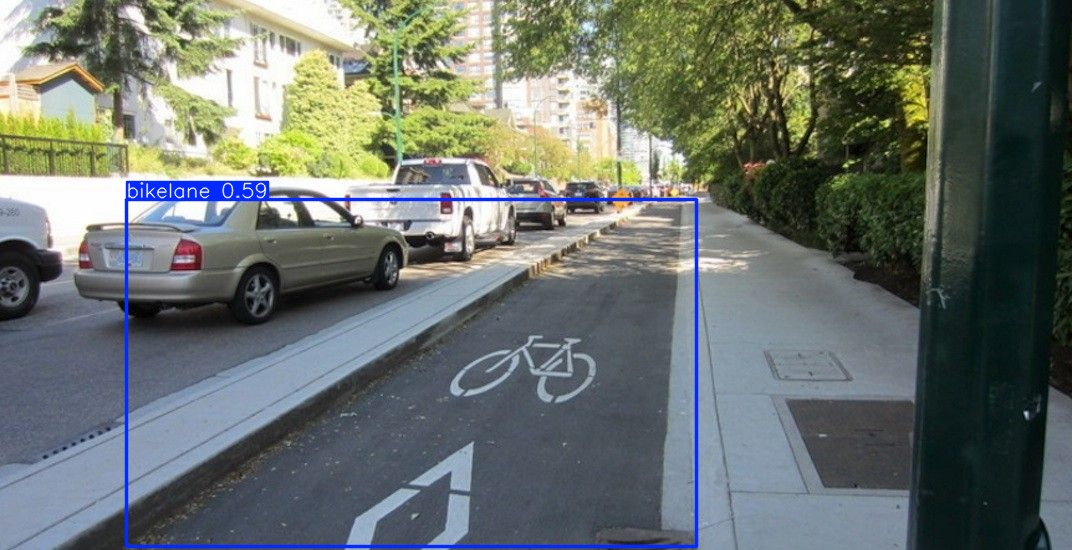

In [15]:
custom_img = "/content/drive/MyDrive/Colab Notebooks/vancouver-bike-lane-pacific-street.jpg"
if os.path.exists(custom_img):
    pred2 = detector.predict(
        source=custom_img,
        conf=0.10,
        imgsz=1280,
        augment=True,
        save=True,
        project="/content/runs/detect",
        name="predict_val_check4"
        # classes=[0]
    )
    show_saved(pred2, custom_img)
else:
    print("Custom image not found:", custom_img)

In [18]:
# Pick any image you want:
test_img = "/content/drive/MyDrive/train/5tdh4ff5tfoa1.jpg"  # <- change this
is_blocked, hits = detect_blocking(
    test_img, lane_conf=0.25, obs_conf=0.35,
    project="/content/runs/detect", name="predict_block_check_custom"
)


Output hidden; open in https://colab.research.google.com to view.

## Evaluation Metrics

[This](https://docs.ultralytics.com/guides/yolo-performance-metrics/) is a very good detailed explanation of different perfromance metrics in YOLO.

**Choosing the Right Metrics**

Choosing the right metrics to evaluate often depends on the specific application.

- mAP: Suitable for a broad assessment of model performance.

- IoU: Essential when precise object location is crucial.

- Precision: Important when minimizing false detections is a priority.

- Recall: Vital when it's important to detect every instance of an object.

- F1 Score: Useful when a balance between precision and recall is needed.


In [ ]:
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map    # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps   # a list contains map50-95 of each category
metrics.box.mp    # P
metrics.box.mr    # R

Ultralytics 8.3.220 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,128,293 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.5±0.2 ms, read: 66.5±27.3 MB/s, size: 146.5 KB)
val: Scanning /content/drive/MyDrive/Datasets/Final_data/labels/val.cache... 33 images, 1 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 33/33 60.4Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 1.4it/s 2.1s
                   all         33         33      0.927      0.909      0.936      0.754
              bikelane         32         33      0.927      0.909      0.936      0.754
Speed: 9.1ms preprocess, 25.5ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to /content/runs/detect/val


np.float64(0.9090909090909091)

Showing confusion matrix, that is already stored in detect/train folder

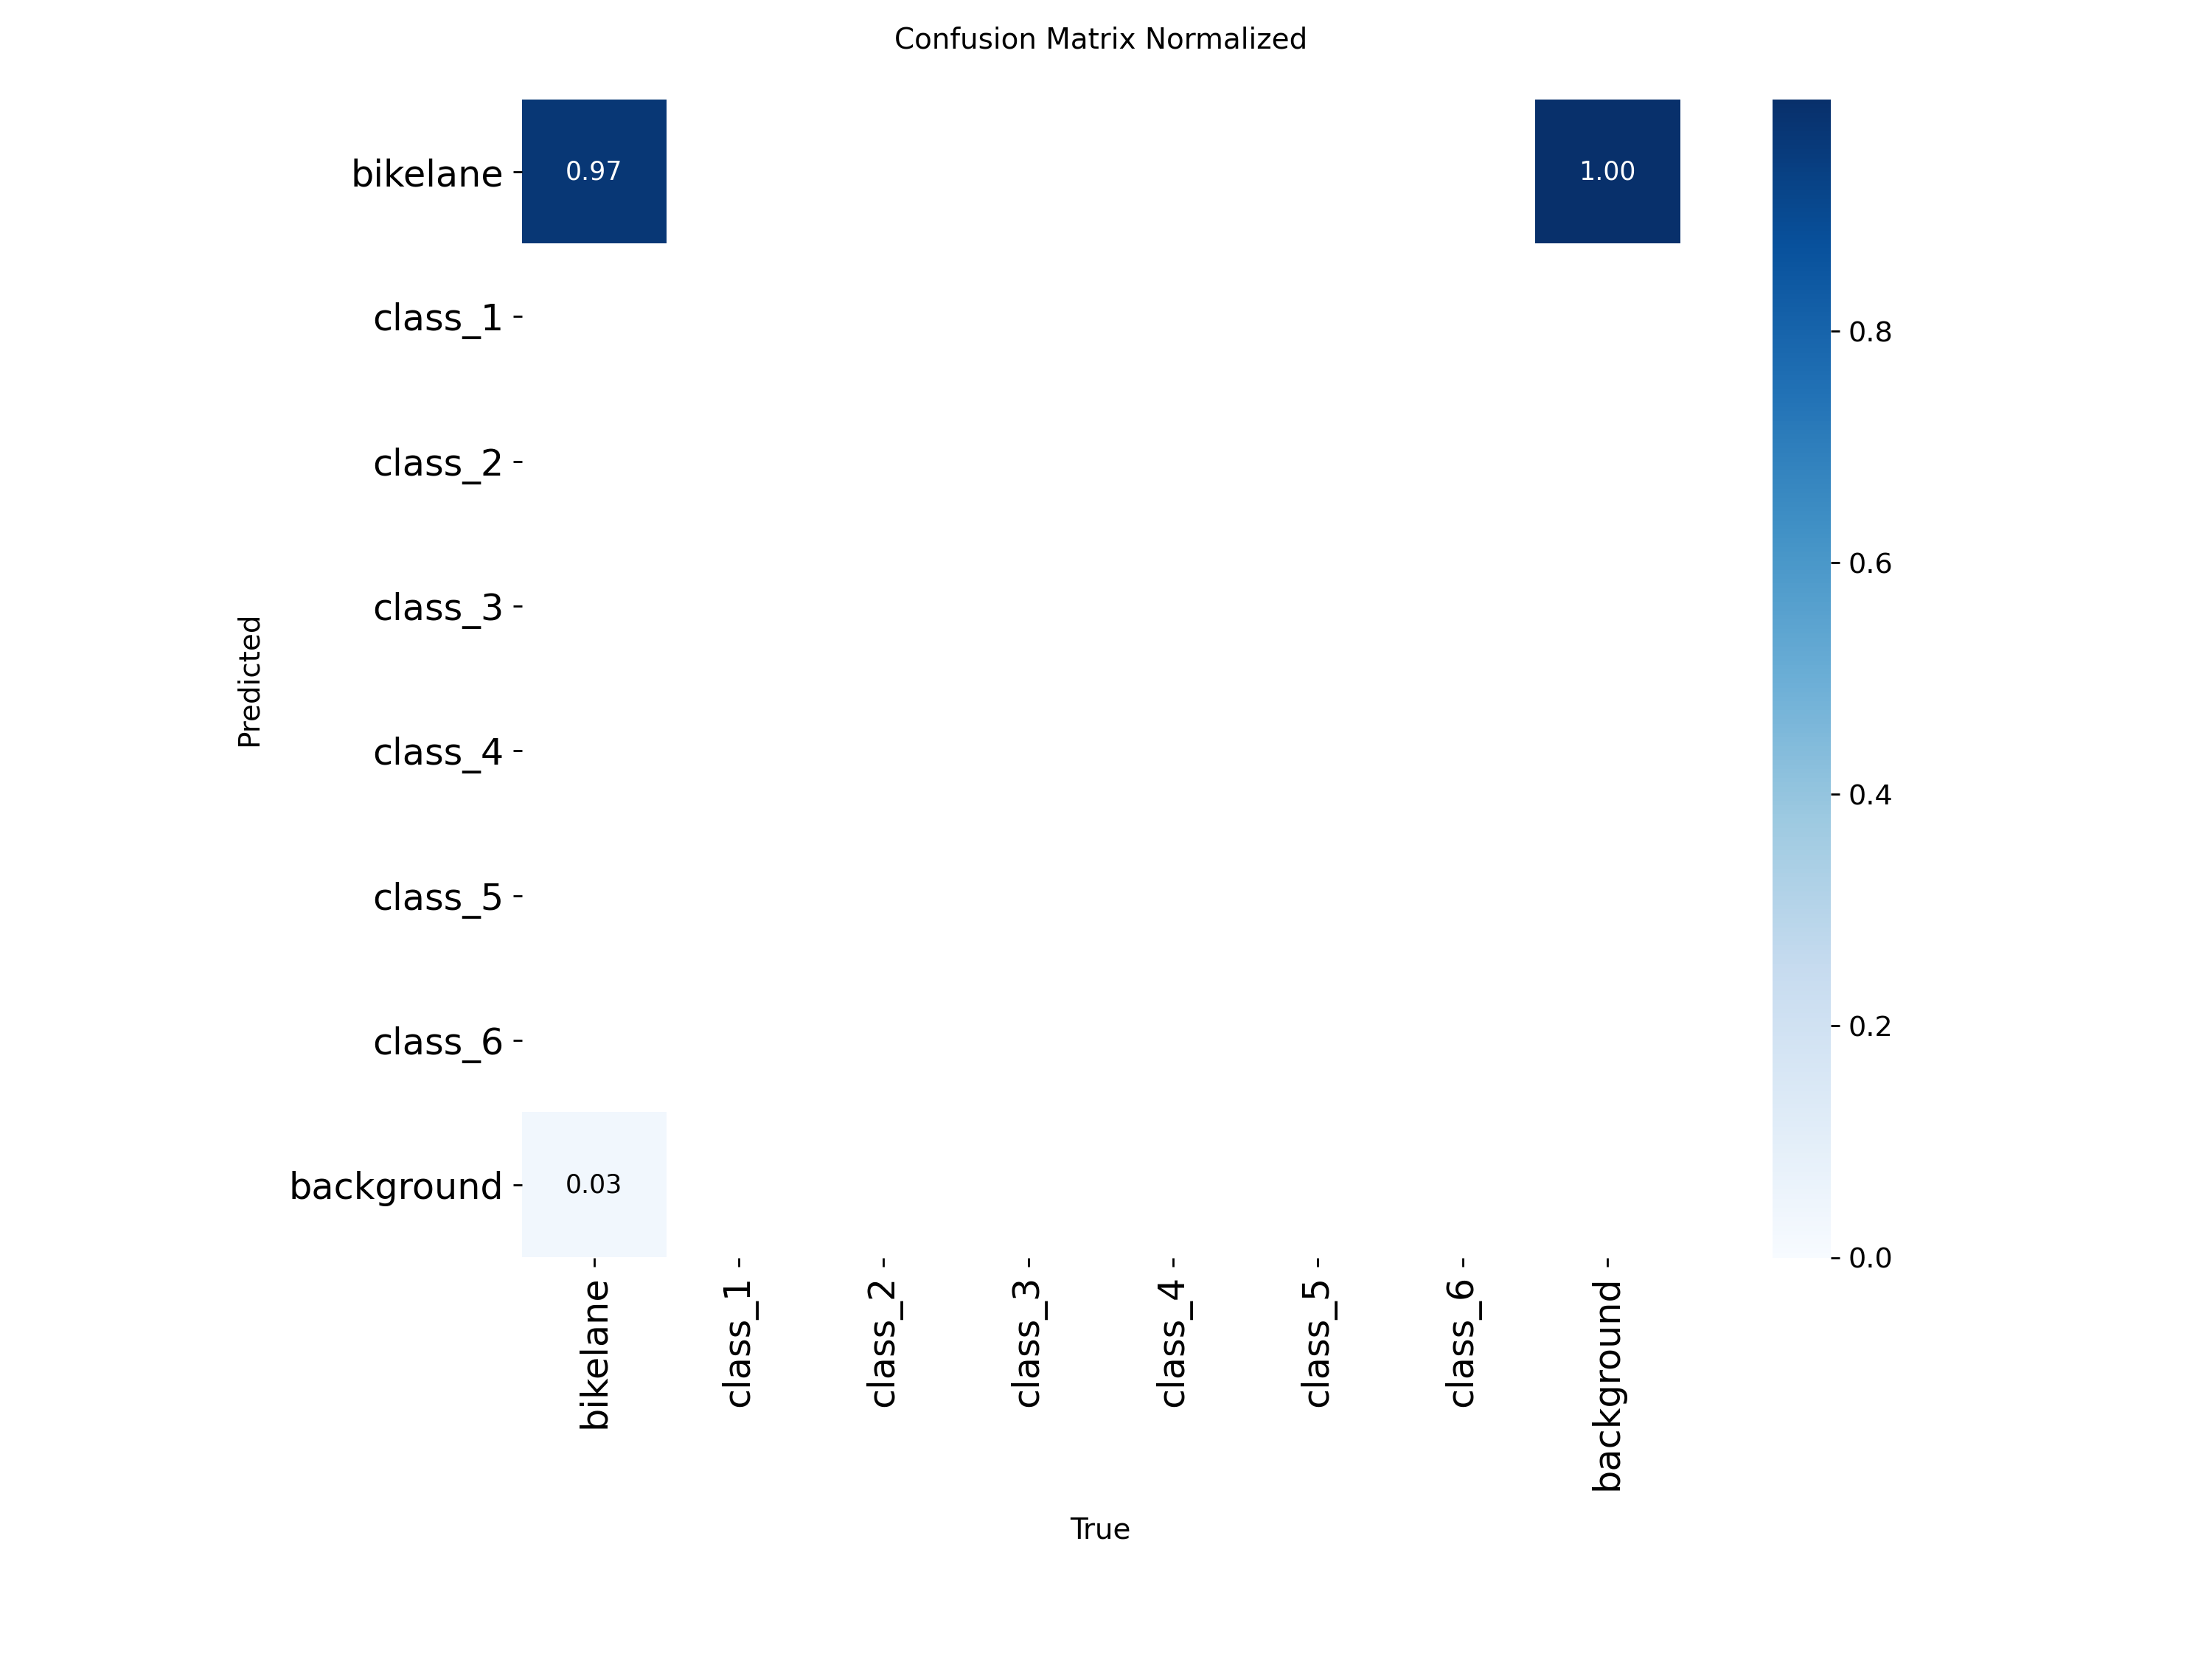

In [ ]:
%matplotlib inline
from PIL import Image

Image.open('/content/runs/detect/val/confusion_matrix_normalized.png')

##Prediction

In [ ]:
model = YOLO('/content/runs/detect/train/weights/best.pt')  # load a custom model

# Predict with the model with any image from internet?
results = model('/content/runs/detect/predict_bikelane/1083_jpg.rf.efba54a4e9328c85fa2d2f6f8f10da91.jpg', save=True)


image 1/1 /content/runs/detect/predict_bikelane/1083_jpg.rf.efba54a4e9328c85fa2d2f6f8f10da91.jpg: 384x640 (no detections), 11.3ms
Speed: 2.4ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Results saved to /content/runs/detect/predict


In [ ]:
# SHOW THE IMAGE STORED
%matplotlib inline
from PIL import Image

Image.open('/content/runs/detect/predict/1083_jpg.rf.efba54a4e9328c85fa2d2f6f8f10da91.jpg')

Output hidden; open in https://colab.research.google.com to view.